In [1]:
def MakePMatrix(omega, which_layer, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list):
    
    det = Uniform_ep_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][2]-Uniform_xi_list[which_layer][2][2]*Uniform_zeta_list[which_layer][2][2]
    
    nuzxee = - (Uniform_mu_list[which_layer][2][2]*Uniform_ep_list[which_layer][2][0]-Uniform_xi_list[which_layer][2][2]*(Uniform_zeta_list[which_layer][2][0]+ky0/omega))/det
    nuzyee = - (Uniform_mu_list[which_layer][2][2]*Uniform_ep_list[which_layer][2][1]-Uniform_xi_list[which_layer][2][2]*(Uniform_zeta_list[which_layer][2][1]-kx0/omega))/det
    nuzxeh = (Uniform_xi_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][0]-Uniform_mu_list[which_layer][2][2]*(Uniform_xi_list[which_layer][2][0]-ky0/omega))/det
    nuzyeh = (Uniform_xi_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][1]-Uniform_mu_list[which_layer][2][2]*(Uniform_xi_list[which_layer][2][1]+kx0/omega))/det
    nuzxhe = (Uniform_zeta_list[which_layer][2][2]*Uniform_ep_list[which_layer][2][0]-Uniform_ep_list[which_layer][2][2]*(Uniform_zeta_list[which_layer][2][0]+ky0/omega))/det
    nuzyhe = (Uniform_zeta_list[which_layer][2][2]*Uniform_ep_list[which_layer][2][1]-Uniform_ep_list[which_layer][2][2]*(Uniform_zeta_list[which_layer][2][1]-kx0/omega))/det
    nuzxhh = - (Uniform_ep_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][0]-Uniform_zeta_list[which_layer][2][2]*(Uniform_xi_list[which_layer][2][0]-ky0/omega))/det
    nuzyhh = - (Uniform_ep_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][1]-Uniform_zeta_list[which_layer][2][2]*(Uniform_xi_list[which_layer][2][1]+kx0/omega))/det   
    
    J = np.ones((4,4), dtype = complex)
    
    P = np.zeros((4,4), dtype = complex)
    
    temp0 = np.array([[Uniform_zeta_list[which_layer][1][0], Uniform_zeta_list[which_layer][1][1], Uniform_mu_list[which_layer][1][0], Uniform_mu_list[which_layer][1][1]], [-Uniform_zeta_list[which_layer][0][0], -Uniform_zeta_list[which_layer][0][1], -Uniform_mu_list[which_layer][0][0], -Uniform_mu_list[which_layer][0][1]], [-Uniform_ep_list[which_layer][1][0], -Uniform_ep_list[which_layer][1][1], -Uniform_xi_list[which_layer][1][0], -Uniform_xi_list[which_layer][1][1]], [Uniform_ep_list[which_layer][0][0], Uniform_ep_list[which_layer][0][1], Uniform_xi_list[which_layer][0][0], Uniform_xi_list[which_layer][0][1]]])
    temp1 = np.diag((Uniform_zeta_list[which_layer][1][2]+kx0/omega, -Uniform_zeta_list[which_layer][0][2]+ky0/omega, -Uniform_ep_list[which_layer][1][2], Uniform_ep_list[which_layer][0][2]))
    temp2 = np.diag((nuzxee, nuzyee, nuzxeh, nuzyeh))
    
    temp3 = np.diag((Uniform_mu_list[which_layer][1][2], -Uniform_mu_list[which_layer][0][2], -Uniform_xi_list[which_layer][1][2]+kx0/omega, Uniform_xi_list[which_layer][0][2]+ky0/omega))
    temp4 = np.diag((nuzxhe, nuzyhe, nuzxhh, nuzyhh))
    
    P = omega*(temp0 + temp1 @ J @ temp2 + temp3 @ J @ temp4)
    
    return P


def Kmatrix(n, theta, phi):
    K   = np.array([[-np.sin(phi), -np.cos(phi)*np.cos(theta), -np.sin(phi), np.cos(phi)*np.cos(theta)], [np.cos(phi), -np.sin(phi)*np.cos(theta), np.cos(phi), np.sin(phi)*np.cos(theta)], [-n/eta0*np.cos(phi)*np.cos(theta), n/eta0*np.sin(phi), n/eta0*np.cos(phi)*np.cos(theta), n/eta0*np.sin(phi)], [-n/eta0*np.sin(phi)*np.cos(theta), -n1/eta0*np.cos(phi), n/eta0*np.sin(phi)*np.cos(theta), -n/eta0*np.cos(phi)]])
    
    return K
    
    
def MakeMMatrix(omega, which_layer, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list):
    
    P = MakePMatrix(omega, which_layer, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list)
    
    w, v = np.linalg.eig(P)

    expG = np.zeros((4, 4), dtype = complex)
    
    for i in range(4):
        expG[i, i] = np.exp(1j*w[i]*thickness_list[which_layer])
    
    M  = v @ expG @ np.linalg.inv(v)
    
    return M

def BandStructure(M, thickness_list):
    
    w, v = np.linalg.eig(M)
    
    q1    = np.log(w)/(1j*np.sum(thickness_list))
    q     = np.zeros(q1.shape, dtype = float)
    
    for j in range(4):
        if np.abs(np.imag(q1[j])/np.abs(q1[j])) < 1e-5:
            q[j] = np.real(q1[j])*np.sum(thickness_list)
        else:
            q[j] = None
    
    sort = np.argsort(q)
    q    = np.sort(q)
    
    return q, sort

def Electric(M, omega, which_layer, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list):
    
    w, v = np.linalg.eig(M)
    
    q, sort = BandStructure(M, thickness_list[which_layer])
    
    vsort = np.zeros(v.shape, dtype = complex)
    for i in range(4):
        vsort[:,i] = v[:,sort[i]]
    
    det = Uniform_ep_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][2]-Uniform_xi_list[which_layer][2][2]*Uniform_zeta_list[which_layer][2][2]
    
    nuzxee = - (Uniform_mu_list[which_layer][2][2]*Uniform_ep_list[which_layer][2][0]-Uniform_xi_list[which_layer][2][2]*(Uniform_zeta_list[which_layer][2][0]+ky0/omega))/det
    nuzyee = - (Uniform_mu_list[which_layer][2][2]*Uniform_ep_list[which_layer][2][1]-Uniform_xi_list[which_layer][2][2]*(Uniform_zeta_list[which_layer][2][1]-kx0/omega))/det
    nuzxeh = (Uniform_xi_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][0]-Uniform_mu_list[which_layer][2][2]*(Uniform_xi_list[which_layer][2][0]-ky0/omega))/det
    nuzyeh = (Uniform_xi_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][1]-Uniform_mu_list[which_layer][2][2]*(Uniform_xi_list[which_layer][2][1]+kx0/omega))/det
    
    vex = np.zeros(4, dtype = complex)
    vey = np.zeros(4, dtype = complex)
    vez = np.zeros(4, dtype = complex)
    
    for i in range(4):
        vex[i] = vsort[0,i]
        vey[i] = vsort[1,i]
        vez[i] = nuzxee*vsort[0,i]+nuzyee*vsort[1,i]+nuzxeh*vsort[2,i]+nuzyeh*vsort[3,i]
    
    return np.array([vex, vey, vez])

def Magnetic(M, omega, which_layer, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list):
    
    w, v = np.linalg.eig(M)
    
    q, sort = BandStructure(M, thickness_list[which_layer])
    
    vsort = np.zeros(v.shape, dtype = complex)
    for i in range(4):
        vsort[:,i] = v[:,sort[i]]
    
    det = Uniform_ep_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][2]-Uniform_xi_list[which_layer][2][2]*Uniform_zeta_list[which_layer][2][2]
    
    nuzxhe = (Uniform_zeta_list[which_layer][2][2]*Uniform_ep_list[which_layer][2][0]-Uniform_ep_list[which_layer][2][2]*(Uniform_zeta_list[which_layer][2][0]+ky0/omega))/det
    nuzyhe = (Uniform_zeta_list[which_layer][2][2]*Uniform_ep_list[which_layer][2][1]-Uniform_ep_list[which_layer][2][2]*(Uniform_zeta_list[which_layer][2][1]-kx0/omega))/det
    nuzxhh = - (Uniform_ep_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][0]-Uniform_zeta_list[which_layer][2][2]*(Uniform_xi_list[which_layer][2][0]-ky0/omega))/det
    nuzyhh = - (Uniform_ep_list[which_layer][2][2]*Uniform_mu_list[which_layer][2][1]-Uniform_zeta_list[which_layer][2][2]*(Uniform_xi_list[which_layer][2][1]+kx0/omega))/det   
    
    vhx = np.zeros(4, dtype = complex)
    vhy = np.zeros(4, dtype = complex)
    vhz = np.zeros(4, dtype = complex)
    
    for i in range(4):
        vhx[i] = vsort[2,i]
        vhy[i] = vsort[3,i]
        vhz[i] = nuzxhe*vsort[0,i]+nuzyhe*vsort[1,i]+nuzxhh*vsort[2,i]+nuzyhh*vsort[3,i]
    
    return np.array([vhx, vhy, vhz])

def Fields(ve, vh, M, incoming, z_offset, x_offset, y_offset, kx0, ky0, thickness):
    
    
    # Suppose we want to find the field in t-th layer,
    # M - Transfer Matrix of the t-th layer, ve, vh - electric and magnetic field eigenvectors in t-th layer, 
    # thickness - thickness of the t-th layer
    
    w, v = np.linalg.eig(M)
    q    = BandStructure(M, thickness)
    
    Coef = np.linalg.inv(v) @ incoming
    
    eh = []
    
    for j in range(len(z_offset)):
        ex = 0; ey = 0; ez = 0; hx = 0; hy = 0; hz = 0
        
        for i in range(4):
            ex += ve[0][i]*np.exp(1j*kx0*x_offset+1j*ky0*y_offset)*np.exp(1j*q[i]*z_offset[j])*Coef[i]
            ey += ve[1][i]*np.exp(1j*kx0*x_offset+1j*ky0*y_offset)*np.exp(1j*q[i]*z_offset[j])*Coef[i]
            ez += ve[2][i]*np.exp(1j*kx0*x_offset+1j*ky0*y_offset)*np.exp(1j*q[i]*z_offset[j])*Coef[i]
            
            hx += vh[0][i]*np.exp(1j*kx0*x_offset+1j*ky0*y_offset)*np.exp(1j*q[i]*z_offset[j])*Coef[i]
            hy += vh[1][i]*np.exp(1j*kx0*x_offset+1j*ky0*y_offset)*np.exp(1j*q[i]*z_offset[j])*Coef[i]
            hz += vh[2][i]*np.exp(1j*kx0*x_offset+1j*ky0*y_offset)*np.exp(1j*q[i]*z_offset[j])*Coef[i]
        
        eh.append([[ex, ey, ez], [hx, hy, hz]])
    
    return eh


def RandT(M):
    r  = np.zeros((2,2), dtype = complex)
    t  = np.zeros((2,2), dtype = complex)
    
    det = (M[2,2]*M[3,3] - M[2,3]*M[3,2])
    
    r[0, 0] = (M[2, 3]*M[3,0]-M[2,0]*M[3,3])/det
    r[0, 1] = (M[2, 3]*M[3,1]-M[2,1]*M[3,3])/det
    r[1, 0] = (M[2, 0]*M[3,2]-M[3,0]*M[2,2])/det
    r[1, 1] = (M[2, 1]*M[3,2]-M[3,1]*M[2,2])/det
    
    t[0, 0] = ((M[0, 2]*M[2, 3]-M[0, 3]*M[2, 2])*M[3, 0]+(M[0, 3]*M[2,0]-M[0,0]*M[2, 3])*M[3,2]+(M[0,0]*M[2,2]-M[0, 2]*M[2,0])*M[3,3])/det
    t[0, 1] = M[0, 1] + ((M[0,2]*M[2,3]-M[0, 3]*M[2,2])*M[3,1]+(M[0, 3]*M[3, 2]-M[0, 2]*M[3,3])*M[2,1])/det
    t[1, 0] = ((M[1,2]*M[2,3]-M[1,3]*M[2,2])*M[3,0]+(M[1,3]*M[2,0]-M[1,0]*M[2,3])*M[3,2]+(M[1,0]*M[2,2]-M[1,2]*M[2,0])*M[3,3])/det
    t[1, 1] = M[1,1] + ((M[1,2]*M[2,3]-M[1,3]*M[2,2])*M[3,1]+(M[1,3]*M[3,2]-M[1,2]*M[3,3])*M[2,1])/det
    
    return r, t
    
def RefTrans(r, t, theta, n1, n2):
    Rss = np.abs(r[0,0])**2
    Rsp = np.abs(r[0,1])**2
    Rps = np.abs(r[1,0])**2
    Rpp = np.abs(r[1,1])**2
    
    thetar  = np.arcsin(n1*np.sin(theta)/n2)
    
    Tss = (n2/n1)*(np.real(np.cos(thetar))/np.cos(theta))*np.abs(t[0,0])**2
    Tsp = (n2/n1)*(np.real(np.cos(thetar))/np.cos(theta))*np.abs(t[0,1])**2
    Tps = (n2/n1)*(np.real(np.cos(thetar))/np.cos(theta))*np.abs(t[1,0])**2
    Tpp = (n2/n1)*(np.real(np.cos(thetar))/np.cos(theta))*np.abs(t[1,1])**2
    
    As = 1 - (Rss+Rps+Tss+Tps)
    Ap = 1 - (Rpp+Rsp+Tpp+Tsp)
    
    return Rss, Rsp, Rps, Rpp, Tss, Tsp, Tps, Tpp, As, Ap

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

def EnDensity(weps, wmu, wgamma, elec1, elec2, mag1, mag2):
    
    coef1 = 1/2*(np.dot(np.conjugate(elec1), weps @ elec1)+np.dot(np.conjugate(mag1), wmu @ mag1)-2/c*np.imag(np.dot(np.conjugate(elec1), wgamma @ mag1)))
    
    coef2 = 1/2*(np.dot(np.conjugate(elec2), weps @ elec2)+np.dot(np.conjugate(mag2), wmu @ mag2)-2/c*np.imag(np.dot(np.conjugate(elec2), wgamma @ mag2)))
        
    elec1 = elec1/np.sqrt(coef1)
    mag1 = mag1/np.sqrt(coef1)
    elec2 = elec2/np.sqrt(coef2)
    mag2 = mag2/np.sqrt(coef2)
    
    
    res   = 1/2*(np.dot(np.conjugate(elec1), weps @ elec2)+np.dot(np.conjugate(mag1), wmu @ mag2)-2/c*np.imag(np.dot(np.conjugate(elec1), wgamma @ mag2)))
        
    return res

def EnDensity3(weps1, weps2, weps3, wmu1, wmu2, wmu3, elec11, elec12, elec13, elec21, elec22, elec23, mag11, mag12, mag13, mag21, mag22, mag23):
    
    coef11 = 1/2*(np.dot(np.conjugate(elec11), weps1 @ elec11)+np.dot(np.conjugate(mag11), wmu1 @ mag11))
    coef12 = 1/2*(np.dot(np.conjugate(elec12), weps2 @ elec12)+np.dot(np.conjugate(mag12), wmu2 @ mag12))
    coef13 = 1/2*(np.dot(np.conjugate(elec13), weps3 @ elec13)+np.dot(np.conjugate(mag13), wmu3 @ mag13))
    
    coef21 = 1/2*(np.dot(np.conjugate(elec21), weps1 @ elec21)+np.dot(np.conjugate(mag21), wmu1 @ mag21))
    coef22 = 1/2*(np.dot(np.conjugate(elec22), weps2 @ elec22)+np.dot(np.conjugate(mag22), wmu2 @ mag22))
    coef23 = 1/2*(np.dot(np.conjugate(elec23), weps3 @ elec23)+np.dot(np.conjugate(mag23), wmu3 @ mag23))
        
    elec11 = elec11/np.sqrt(coef11+coef12+coef13)
    elec12 = elec12/np.sqrt(coef11+coef12+coef13)
    elec13 = elec13/np.sqrt(coef11+coef12+coef13)
    mag11  = mag11/np.sqrt(coef11+coef12+coef13)
    mag12  = mag12/np.sqrt(coef11+coef12+coef13)
    mag13  = mag13/np.sqrt(coef11+coef12+coef13)
                  
    elec21 = elec21/np.sqrt(coef21+coef22+coef23)
    elec22 = elec22/np.sqrt(coef21+coef22+coef23)
    elec23 = elec23/np.sqrt(coef21+coef22+coef23)
    mag21  = mag21/np.sqrt(coef21+coef22+coef23)
    mag22  = mag22/np.sqrt(coef21+coef22+coef23)
    mag23  = mag23/np.sqrt(coef21+coef22+coef23)
    
    
    res1   = 1/2*(np.dot(np.conjugate(elec11), weps1 @ elec21)+np.dot(np.conjugate(mag11), wmu1 @ mag21))
    res2   = 1/2*(np.dot(np.conjugate(elec12), weps2 @ elec22)+np.dot(np.conjugate(mag12), wmu2 @ mag22))
    res3   = 1/2*(np.dot(np.conjugate(elec13), weps3 @ elec23)+np.dot(np.conjugate(mag13), wmu3 @ mag23))
                  
    return res1+res2+res3

In [2]:
import numpy as np

# helix parameters
a    = 1e-6
rhox = 0.2*a
rhoy = 0.1*a
p    = 0.2*a

# parameter C
C00  = 28.5
C11  = 13.7
Cp11 = 8.1

A     = np.pi*rhox*rhoy/p
Vcell = a**2*p
Bp2   = 2*np.pi/np.sqrt(C00*Vcell)
Bp1   = 2*np.pi*p/np.sqrt(Vcell*(C00*p**2+4*np.pi**2*(Cp11*rhox**2+C11*rhoy**2)))

#permittivities


In [9]:
import numpy as np
import scipy as sp
import scipy.constants as spcs
from numpy.linalg import matrix_power

# universal constants 
c       = spcs.c
eps0    = spcs.epsilon_0
mu0     = spcs.mu_0
eta0    = np.sqrt(mu0/eps0)

# problem parameters 
m       = 1000
length  = 1e-6
omega   = np.linspace(0.5e-4*np.pi*c/length, 0.65*np.pi*c/length, m)



omega_p = 0.5*np.pi*c/length

kx0     = 0.
ky0     = 0.

    
# material parameters

q1    = np.zeros((m, 4), dtype = float)

for i in range(m):
    
    mu_z = (1 + A**2*Bp1**2)**(-1)
    gamma_z = mu_z * (A*Bp1**2/(2*omega[i]))
    
    epsA = np.array([[1 + (np.pi*rhox)**2/(Vcell*C11), 0, 0], [0, 1 + (np.pi*rhoy)**2/(Vcell*Cp11), 0], [0, 0, 1 - Bp1**2/omega[i]**2-gamma_z**2/mu_z]])*eps0
    muA  = np.array([[1., 0, 0], [0, 1., 0], [0, 0, mu_z]])*mu0
    xiA  = np.array([[0, 0, 0], [0, 0, 0], [0, 0, gamma_z]])*1j*np.sqrt(eps0*mu0)
    zetA = -xiA
    dA   = length
    
    Uniform_ep_list = [epsA]
    Uniform_mu_list = [muA]
    Uniform_xi_list = [xiA]
    Uniform_zeta_list = [zetA]
    thickness_list  = [dA]
    
    M1 = MakeMMatrix(omega[i], 0, kx0, ky0, Uniform_ep_list, Uniform_mu_list, Uniform_xi_list, Uniform_zeta_list, thickness_list)
   
    q1[i], sort  = BandStructure(M1, thickness_list)
    
    
    Uniform_ep_list = []
    Uniform_mu_list = []
    Uniform_xi_list = []
    Uniform_zeta_list = []
    thickness_list  = []

(-3.141592653589793, 3.141592653589793)

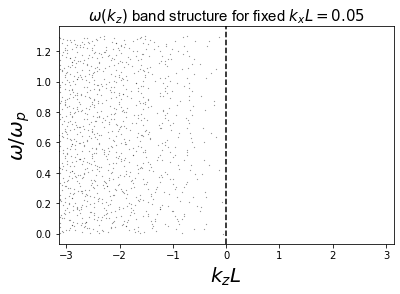

In [10]:
from matplotlib import pyplot as plt 

plt.figure(figsize=(6,4))

plt.title(r'$\omega(k_z)$ band structure for fixed $k_x L = 0.05$', fontname = "Arial", fontsize = 15)
plt.xlabel(r"$k_z L$", fontname = "Arial", fontsize = 20)
plt.ylabel(r"$\omega/\omega_p$", fontsize = 20)
plt.scatter(q1[:, 0], omega/omega_p,s = 0.1, marker='.',  color = "black")
#plt.scatter(q1[:, 1], omega/omega_p,s = 0.1, marker='.', color = "black")
#plt.scatter(q1[:, 2], omega/omega_p,s = 0.1, marker='.', color = "black")
#plt.scatter(q1[:, 3], omega/omega_p,s = 0.1, marker='.', color = "black")
plt.axvline(0, linestyle='--', color='k')
plt.xlim([-np.pi, np.pi])